In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
!python3 -m pip install keras
import tensorflow as tf
from tensorflow import keras
from keras import regularizers


# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pdb
from six.moves import cPickle as pickle
import os
from scipy import ndimage

Using TensorFlow backend.


In [3]:
def extract_dataset():
    with open('../data/notMNIST_sanit.pickle', 'rb') as f:
        data = pickle.load(f)
    return data

def image_name(index):
  return chr(ord('A') + index)

In [4]:
dataset = extract_dataset()
train_images = dataset['train_dataset']
train_labels = dataset['train_labels']
valid_images = dataset['valid_dataset']
valid_labels = dataset['valid_labels']
test_images = dataset['test_dataset']
test_labels = dataset['test_labels']

1: Реализуйте полносвязную нейронную сеть с помощью библиотеки Tensor Flow.
В качестве алгоритма оптимизации можно использовать, например стохастический градиент (Stochastic Gradient Descent, SGD). Определите количество скрытых слоев от 1 до 5, количество нейронов в каждом из слоев до нескольких сотен, а также их функции активации (кусочно-линейная, сигмоидная, гиперболический тангенс и т.д.).


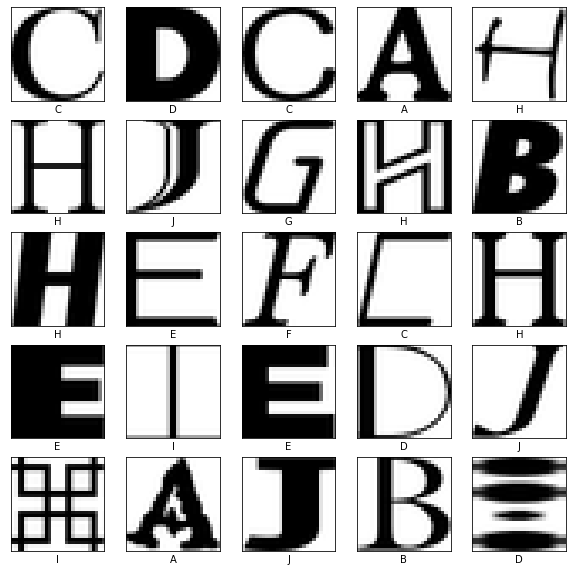

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(image_name(train_labels[i]))
plt.show()

In [6]:
# Flatten преобразует формат изображения из двумерного массива (28 на 28 пикселей)
# в одномерный (размерностью 28 * 28 = 784 пикселя)
# Dense - это полносвязные нейронные слои.
baseline_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(20, activation='sigmoid'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [7]:
baseline_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

baseline_model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

baseline_model.summary()

baseline_history = baseline_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = baseline_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16955 samples
Epoch 1/10
200000/200000 [==============================] - 12s 61us/sample - loss: 0.8510 - accuracy: 0.7808 - sparse_categorical_crossentropy: 0.8510 - val_loss: 0.6956 - val_accuracy: 0.8128 - v

Задание 2.
Как улучшилась точность классификатора по сравнению с логистической регрессией?

Логистическая регрессия давала результат в 0.8985 точности, нейронная сеть с тремя слоями выдает результат уже лучше: 0.9144495.

3: Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением.
Как улучшилось качество классификации?

In [8]:
#3.1 Регуляризация
# https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#add_weight_regularization

l2_regularization = 1e-4

l2_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dense(10, activation='softmax')
])

l2_model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

l2_model_history = l2_model.fit(train_images,
                                train_labels,
                                epochs=10,
                                validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = l2_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Train on 200000 samples, validate on 16955 samples
Epoch 1/10
200000/200000 [==============================] - 12s 62us/sample - loss: 0.8826 - accuracy: 0.7804 - sparse_categorical_crossentropy: 0.8526 - val_loss: 0.7277 - val_accuracy: 0.8110 - val_sparse_categorical_crossentropy: 0.6969
Epoch 2/10
200000/200000 [==============================] - 12s 60us/sample - loss: 0.6561 - accuracy: 0.8283 - sparse_categorical_crossentropy: 0.6251 - val_loss: 0.6783 - val_accuracy: 0.8206 - val_sparse_categorical_crossentropy: 0.6471
Epoch 3/10
200000/200000 [==============================] - 12s 61us/sample - loss: 0.6160 - accuracy: 0.8361 - sparse_categorical_crossentropy: 0.5845 - val_loss: 0.6461 - val_accuracy: 0.8268 - val_sparse_categorical_crossentropy: 0.6144
Epoch 4/10
200000/200000 [==============================] - 12s 60us/sample - loss: 0.5860 - accuracy: 0.8412 - sparse_categorical_crossentropy: 0.5541 - val_loss: 0.6179 - val_accuracy: 0.8321 - val_sparse_categorical_crossentro

In [17]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                        '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    
    plt.show()

Регуляризация показала худшие результаты, чем исходная модель (0.9094037 против 0.9144495).

In [9]:
# 3.2 метод сброса нейронов

dropout_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

dropout_model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

dropout_model_history = dropout_model.fit(train_images,
                                train_labels,
                                epochs=10,
                                validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = dropout_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Train on 200000 samples, validate on 16955 samples
Epoch 1/10
200000/200000 [==============================] - 13s 64us/sample - loss: 1.4087 - accuracy: 0.5373 - sparse_categorical_crossentropy: 1.4087 - val_loss: 0.7901 - val_accuracy: 0.7849 - val_sparse_categorical_crossentropy: 0.7901
Epoch 2/10
200000/200000 [==============================] - 13s 66us/sample - loss: 0.9326 - accuracy: 0.7283 - sparse_categorical_crossentropy: 0.9326 - val_loss: 0.6838 - val_accuracy: 0.8015 - val_sparse_categorical_crossentropy: 0.6838
Epoch 3/10
200000/200000 [==============================] - 19s 94us/sample - loss: 0.8280 - accuracy: 0.7616 - sparse_categorical_crossentropy: 0.8280 - val_loss: 0.6498 - val_accuracy: 0.8060 - val_sparse_categorical_crossentropy: 0.6498
Epoch 4/10
200000/200000 [==============================] - 14s 69us/sample - loss: 0.7785 - accuracy: 0.7746 - sparse_categorical_crossentropy: 0.7785 - val_loss: 0.6275 - val_accuracy: 0.8094 - val_sparse_categorical_crossentro

Точность на проверочных данных: (0.890367 против 0.9144495 у исходной модели).

In [10]:
# 3.3 регуляризация + дропаут

l2_dropout_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

l2_dropout_model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

l2_dropout_model_history = l2_dropout_model.fit(train_images,
                                train_labels,
                                epochs=10,
                                validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = l2_dropout_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Train on 200000 samples, validate on 16955 samples
Epoch 1/10
200000/200000 [==============================] - 13s 66us/sample - loss: 1.4573 - accuracy: 0.5328 - sparse_categorical_crossentropy: 1.4278 - val_loss: 0.8298 - val_accuracy: 0.7867 - val_sparse_categorical_crossentropy: 0.7985
Epoch 2/10
200000/200000 [==============================] - 14s 70us/sample - loss: 0.9807 - accuracy: 0.7248 - sparse_categorical_crossentropy: 0.9482 - val_loss: 0.7244 - val_accuracy: 0.7995 - val_sparse_categorical_crossentropy: 0.6909
Epoch 3/10
200000/200000 [==============================] - 14s 68us/sample - loss: 0.8698 - accuracy: 0.7593 - sparse_categorical_crossentropy: 0.8355 - val_loss: 0.6861 - val_accuracy: 0.8057 - val_sparse_categorical_crossentropy: 0.6510
Epoch 4/10
200000/200000 [==============================] - 14s 69us/sample - loss: 0.8191 - accuracy: 0.7738 - sparse_categorical_crossentropy: 0.7833 - val_loss: 0.6662 - val_accuracy: 0.8093 - val_sparse_categorical_crossentro

Точность на проверочных данных: ( 0.89220184 против 0.9144495 у исходной модели).

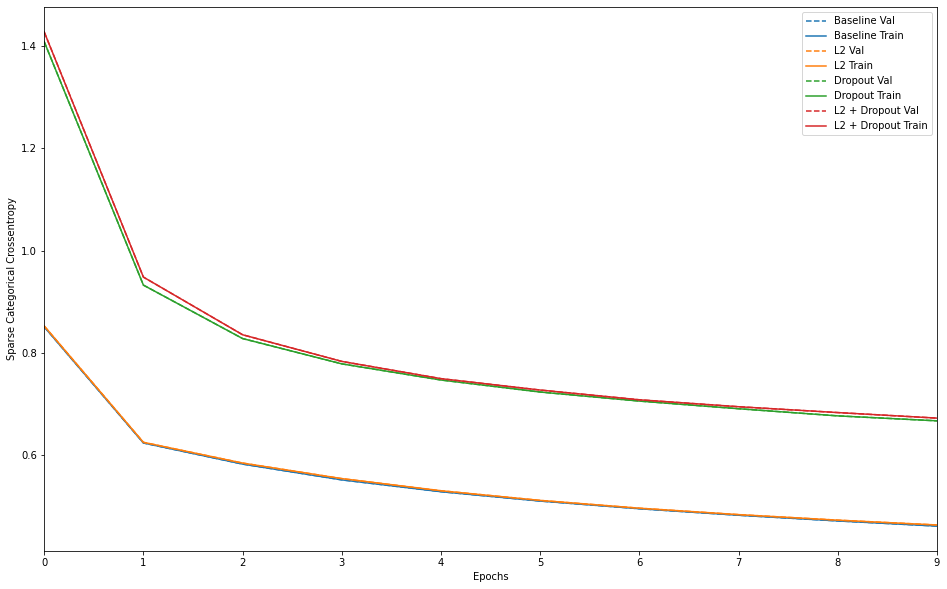

In [18]:
plot_history(
    [
        ('baseline', baseline_history),
        ('l2', l2_model_history),
        ('dropout', dropout_model_history),
        ('l2 + dropout', l2_dropout_model_history)
    ],
             key='sparse_categorical_crossentropy')


В итоге, дропаут только ухудшил результат модели, регуляризация её не ухудшила, но и лучших результатов не показала. Можно сделать вывод, что так как эти методы применяются для борьбы с переобучением модели, то если они ничего не улучшают, значит модель изначально не была переобучена.

Задание 4.
Воспользуйтесь динамически изменяемой скоростью обучения (learning rate).
Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%.
Какую точность демонстрирует Ваша реализованная модель?

In [12]:
# Adagrad

adagrad_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
adagrad_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

adagrad_model.summary()

adagrad_history = adagrad_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = adagrad_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16955 samples
Epoch 1/10
200000/200000 [==============================] - 14s 68us/sample - loss: 0.7136 - accuracy: 0.8096 - sparse_categorical_crossentropy: 0.7136 - val_loss: 0.6464 - val_accuracy: 0.8225 - v

In [13]:
# Adadelta

# Adadelta - это расширение Adagrad,
# которое стремится уменьшить свою агрессивную,
# монотонно уменьшающуюся скорость обучения.

adadelta_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
adadelta_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

adadelta_model.summary()

adadelta_history = adadelta_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = adadelta_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16955 samples
Epoch 1/10
200000/200000 [==============================] - 15s 75us/sample - loss: 0.5904 - accuracy: 0.8331 - sparse_categorical_crossentropy: 0.5904 - val_loss: 0.5381 - val_accuracy: 0.8393 - v

In [14]:
# RMSprop

# RMSprop очень просто настраивает метод Адаграда,
# пытаясь уменьшить его агрессивное, монотонно убывающее обучение.

rms_prop_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
rms_prop_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

rms_prop_model.summary()

rms_prop_history = rms_prop_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = rms_prop_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16955 samples
Epoch 1/10
200000/200000 [==============================] - 20s 99us/sample - loss: 0.5194 - accuracy: 0.8464 - sparse_categorical_crossentropy: 0.5194 - val_loss: 0.4812 - val_accuracy: 0.8531 - v

In [15]:
# Adam

# Adam - это обновление оптимизатора RMSProp,
# похожее на RMSprop с динамикой.

adam_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
adam_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

adam_model.summary()

adam_history = adam_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = adam_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16955 samples
Epoch 1/10
200000/200000 [==============================] - 17s 86us/sample - loss: 0.5218 - accuracy: 0.8450 - sparse_categorical_crossentropy: 0.5218 - val_loss: 0.4781 - val_accuracy: 0.8530 - v

In [16]:
plot_history(
    [
        ('adagrad', adagrad_history),
        ('adadelta', adadelta_history),
        ('rms_prop', rms_prop_history),
        ('adam', adam_history)
    ],
    key='sparse_categorical_crossentropy')

NameError: name 'plot_history' is not defined